# Prerequisites

In [1]:
import os, sys

import numpy as np
import tqdm
import torch

/home/marco/miniconda3/envs/nlp2022-hw3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Important paths for the notebook:

In [2]:
app_root = '../../../../'
test_name = 'test1_noentities'
datasets_path = os.path.join(app_root, 'data')
model_dir_path = os.path.join(app_root, 'model', test_name)

data_train_path = os.path.join(datasets_path, 'train.tsv')
data_dev_path = os.path.join(datasets_path, 'dev.tsv')

In [3]:
sys.path.append('../../../')

%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [4]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
global_params = {
    'batch_size': 32,
    'PAD_TOKEN': '<pad>',
    'UNK_TOKEN': '<unk>',
    'transformer_name': "bert-base-cased",
    'mention_tags': {
        'p_open':  '<P>', 'p_close':  '</P>', 
        'e_open':  '<E>', 'e_close':  '</E>', 
    },
}

# Dataset

In [6]:
from stud.modelsTests.dataset.Dataset_transformer_simple_multilogits import Dataset_transformer_simple_multilogits

In [7]:
dataset_train = Dataset_transformer_simple_multilogits(
    data_train_path, 
    tokenizer = global_params['transformer_name'])

dataset_dev = Dataset_transformer_simple_multilogits(
    data_dev_path, 
    tokenizer = global_params['transformer_name'])

In [8]:
global_params.update({ 
    'token_embeddings_len': len(dataset_train.tokenizer),
    'resize_token_embeddings': False, # ! not used
})

In [9]:
np.save(os.path.join(model_dir_path, 'global_params.npy'), global_params)

# Dataloader

In [10]:
from torch.utils.data import DataLoader

In [11]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
num_workers = 4

In [12]:
dataloader_train = DataLoader(
    dataset_train,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train.create_collate_fn(),
    num_workers=num_workers,
    shuffle=True,
)

dataloader_dev = DataLoader(
    dataset_dev,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev.create_collate_fn(),
    num_workers=num_workers,
    shuffle=False,
)

In [13]:
for e in dataloader_dev:
    ex_in = e
    break

In [14]:
ex_in.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'words_ids', 'predicted_entity_ids', 'predicted_entities', 'gold_entity_ids', 'gold_entities'])

In [15]:
idx = 1
print(ex_in['words_ids'][idx])
ex_in['predicted_entity_ids'][idx], ex_in['gold_entity_ids'][idx]


[-1, 0, 1, 1, 2, 3, 4, 5, 5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 16, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 30, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 43, 43, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


({8821: {'name': 'Ellen', 'offset': 110},
  15182: {'name': 'Kathleen', 'offset': 150}},
 {15182: {'name': 'Kathleen', 'offset': 150}})

In [16]:
print(ex_in['input_ids'][idx][:120], ex_in['input_ids'].shape)
print(ex_in['predicted_entities'][idx][:120],  ex_in['predicted_entities'].shape)
print(ex_in['gold_entities'][idx][:120],  ex_in['gold_entities'].shape)

tensor([  101, 15182,  1753,  1204,  1108,  1255,  1107, 14805,  3169,  3192,
          117,  1498,   119,  1430,  1401,   117,  4367,   117,  1108,   170,
         4941, 27892, 27229, 17588,   117,  1105,  1123,  1534,   117,  8821,
          117,  1868,   170,  9678,  1402,  1107,   139, 14799,  1633,   132,
        15182,  1108,  1147,  1503,  1797,   119,  1153,  1108,  4512,  1120,
         2090, 10136,  6943, 19773,  1197,  4808,   112,  1323,   113,  1208,
         1804,   114,   117,  1498,   117,  1196,  6546,  1624,   112,   188,
         1531,   117,  1498,   119,   102,  1153,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]) torch.Size([32, 136])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0

# Printing model

In [17]:
from stud.modelsTests.utils.print_infos import print_summary, display_history, plot_confusion_matrix, print_classification_report

# Fine-tuning the model

In [18]:
from stud.modelsTests.model_3.model3_transformer_simple_multilogits import Model3
import torch.optim as optim

loss_function = torch.nn.BCELoss()

final_model = Model3(
    device = device,
    loss_fn = loss_function,
    model_load_weights = False,
    fine_tune_transformer = True,
    use_entities = False, # !
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
freeze_some = False
if freeze_some:
    unfreeze_word_embeddings = False
    unfreeze_transformer_layers = True
    unfreeze_from_layer_num = 8
    unfreeze_to_layer_num = 99
    unfreeze_pooler = True

    for name, param in final_model.model.named_parameters():

        if name.startswith('transformer_model.embeddings'):
            param.requires_grad = unfreeze_word_embeddings

        elif name.startswith('transformer_model.encoder.layer'):
            layer_num = int(name.split('.')[3])
            if layer_num >= unfreeze_from_layer_num and layer_num <= unfreeze_to_layer_num:
                param.requires_grad = unfreeze_transformer_layers
            else:
                param.requires_grad = False

        elif name.startswith('transformer_model.pooler'):
            param.requires_grad = unfreeze_pooler
        
        print(param.requires_grad, name)

In [20]:
print_summary(final_model.model)

Model3_net(
  (transformer_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [21]:
ex_in_simple = dataset_dev.create_collate_fn()([dataset_dev[0], dataset_dev[1], dataset_dev[2]])
predictions = final_model.model(
    input_ids = ex_in_simple['input_ids'].to(device), 
    attention_mask = ex_in_simple['attention_mask'].to(device),
    token_type_ids = ex_in_simple['token_type_ids'].to(device),
    predicted_entities = ex_in_simple['predicted_entities'].to(device),
)
labels = ex_in_simple['gold_entities'].to(device)

print(labels)
print(predictions)
print(final_model.model.compute_loss(predictions, labels ))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [22]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
print(final_model.predict(dataset_dev.data_raw[0]))

(('him', 256), ('[unused65]', 270))


In [23]:
history = {}

In [28]:
from stud.modelsTests.utils.Trainer_model3_transformer_simple_multilogits import Trainer_model3_transformer_simple_multilogits

trainer = Trainer_model3_transformer_simple_multilogits()

history = trainer.train(
    final_model, optimizer, dataloader_train, dataloader_dev,
    epochs=40, device=device,
    save_best=True, 
    min_score=0.63,
    save_path_name=os.path.join(model_dir_path, 'model3_weights_transformer_simple_multilogits_noentities.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.005931
#               Validation loss => 0.008505 | accuracy: 0.625551 #
Epoch   1 => avg_loss: 0.005974
#               Validation loss => 0.008293 | accuracy: 0.618943 #
Epoch   2 => avg_loss: 0.005732
#               Validation loss => 0.008434 | accuracy: 0.632159 #
----- Best value obtained, saving model -----
Epoch   3 => avg_loss: 0.005666
#               Validation loss => 0.008445 | accuracy: 0.634361 #
----- Best value obtained, saving model -----
Epoch   4 => avg_loss: 0.005776
#               Validation loss => 0.008409 | accuracy: 0.627753 #
Epoch   5 => avg_loss: 0.005795
#               Validation loss => 0.008347 | accuracy: 0.623348 #
Epoch   6 => avg_loss: 0.005662
#               Validation loss => 0.008494 | accuracy: 0.638767 #
----- Best value obtained, saving model -----
Epoch   7 => avg_loss: 0.005668
#               Validation loss => 0.008567 | accuracy: 0.636564 #
Epoch   8 => avg_loss: 0.005746
#               Validation loss => 0.0

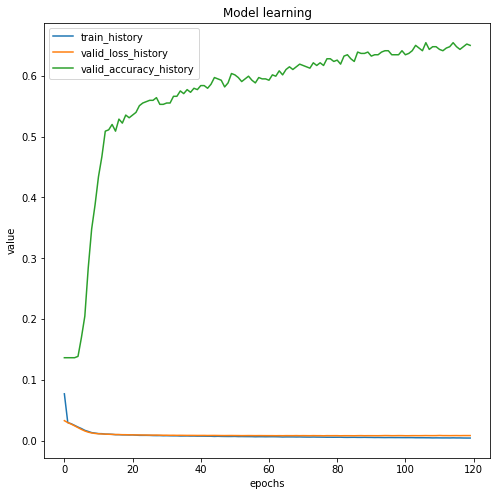

In [29]:
display_history(history)

In [26]:
dataset_dev.data_raw[1]

{'id': 'validation-2',
 'text': "Kathleen Nott was born in Camberwell, London. Her father, Philip, was a lithographic printer, and her mother, Ellen, ran a boarding house in Brixton; Kathleen was their third daughter. She was educated at Mary Datchelor Girls' School (now closed), London, before attending King's College, London.",
 'pron': 'She',
 'p_offset': 185,
 'entity_A': 'Ellen',
 'offset_A': 110,
 'is_coref_A': 'FALSE',
 'entity_B': 'Kathleen',
 'offset_B': 150,
 'is_coref_B': 'TRUE'}

In [27]:
print(final_model.predict(dataset_dev.data_raw[1]))

(('She', 185), ('Kathleen', 150))
